In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pandas
import sqlite3
import pymc3
import seaborn as sns

In [ ]:
con = sqlite3.connect('/tmp/data.sqlite3')
try:
    data = pandas.read_sql('''
        SELECT week_num,
               sales_depo,
               sales_channel,
               route_id,
               client_id,
               product_id,
               adjusted_demand,
               rand
          FROM data 
         WHERE adjusted_demand is not null 
               AND rand=?
               AND week_num < 8''', con=con, params=[np.random.randint(100)])
finally:
    con.close()

In [ ]:
pandas.Series({col: data[col].nunique() for col in data})

In [ ]:
data.sales_channel = data.sales_channel.astype('category')
data.week_num = data.week_num.astype('category')
data.sales_depo = data.sales_depo.astype('category')

In [ ]:
def simple_halfnorm_priors(name_prefix, shape):
    prior_mean = pymc3.HalfNormal(name_prefix + '_pr_mu', 10)
    prior_var  = pymc3.HalfNormal(name_prefix + '_pr_sd', 10)
    return pymc3.Normal(name_prefix, prior_mean, prior_var, shape=shape)

In [ ]:
import theano
import theano.tensor as T

In [ ]:
simple_model = pymc3.Model()
samp = data.sample(1000)

week_var        = theano.shared(value=samp.week_num.cat.codes.values, name='week_var')
sales_chans_var = theano.shared(value=samp.sales_channel.cat.codes.values, name='sales_chans_var')
sales_depo_var  = theano.shared(value=samp.sales_depo.cat.codes.values, name='sales_depo_var')
adj_demand_var  = theano.shared(value=samp.adjusted_demand.values, name='adj_demand_var')

with simple_model:
    week_rate = simple_halfnorm_priors('week', data.week_num.nunique())
    sales_channel = simple_halfnorm_priors('sales_channel', shape=data.sales_channel.nunique())
    sales_depo = simple_halfnorm_priors('sales_depo', shape=data.sales_depo.nunique())
    
    week_vs = week_rate[week_var]
    sales_channel_vs = sales_channel[sales_chans_var]
    sales_depo_vs = sales_depo[sales_depo_var]
    
    demand_mu = week_vs + sales_channel_vs + sales_depo_vs  
    
    adjusted_demand = pymc3.Poisson(
        'adjusted_demand',
        demand_mu,
        observed=adj_demand_var
    )

 [-----------------100%-----------------] 200 of 200 complete in 0.6 sec

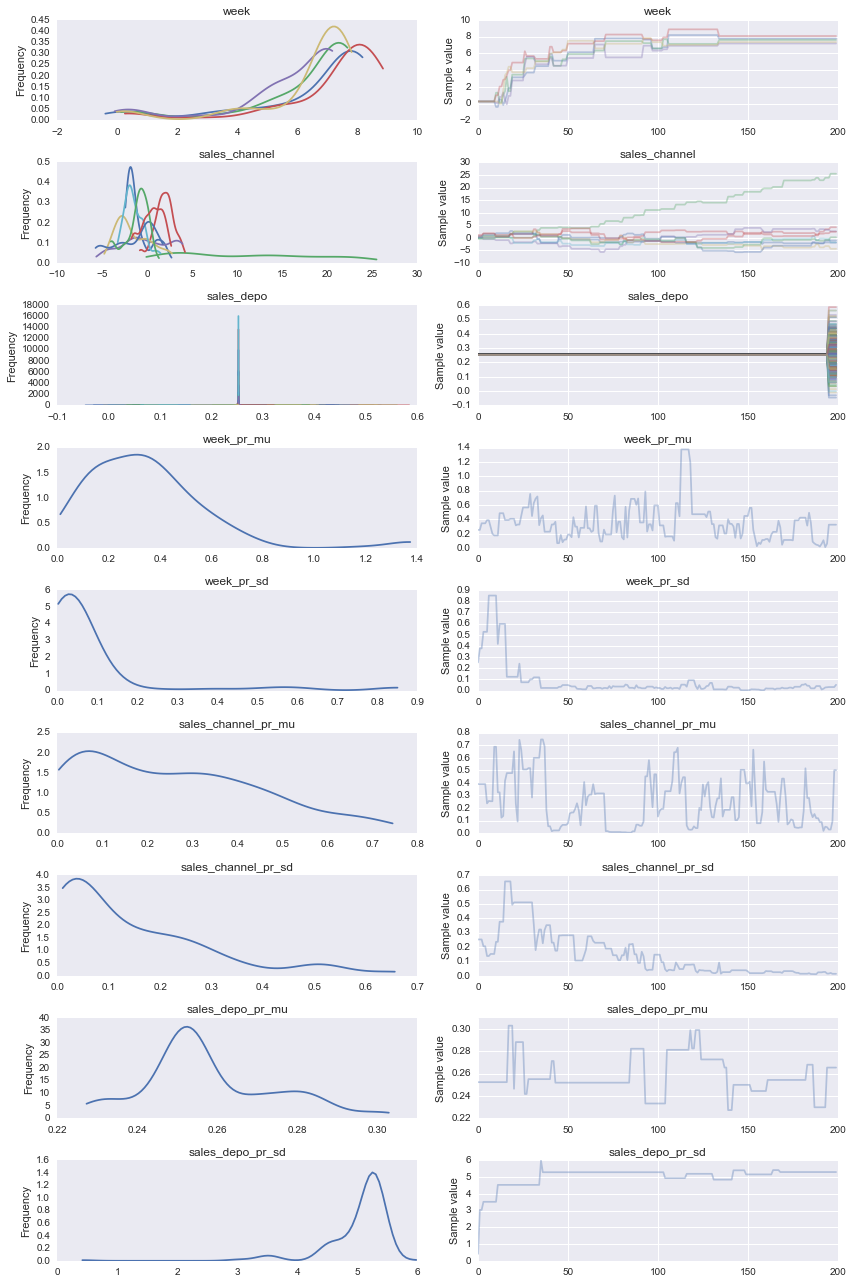

In [23]:
with simple_model:
    trace = pymc3.sample(200, step=pymc3.Metropolis())
    pymc3.traceplot(trace)

In [ ]:
def create_minibatch(data):
    rng = np.random.RandomState(0)

    while True:
        ixs = rng.randint(len(data), size=5000)
        yield data[ixs]

minibatches = zip(*[
    create_minibatch(data.week_num.cat.codes.values),
    create_minibatch(data.sales_channel.cat.codes.values),
    create_minibatch(data.sales_depo.cat.codes.values),

    create_minibatch(data.adjusted_demand.values)
])

def minibatcher():
    while True:
        sample = data.sample(10000)
        yield [
            sample.week_num.cat.codes.values,
            sample.sales_channel.cat.codes.values,
            sample.sales_depo.cat.codes.values,
                
            sample.adjusted_demand.values,
        ]
        
minibatch_tensors = [week_var,
                     sales_chans_var, 
                     sales_depo_var,
                     adj_demand_var]


In [ ]:
next(minibatches)

Iteration 0 [0%]: ELBO = -inf
Iteration 100000 [10%]: Average ELBO = -inf
Iteration 200000 [20%]: Average ELBO = -inf
Iteration 300000 [30%]: Average ELBO = -inf
Iteration 400000 [40%]: Average ELBO = -inf
Iteration 500000 [50%]: Average ELBO = -inf
Iteration 600000 [60%]: Average ELBO = -inf
Iteration 700000 [70%]: Average ELBO = -inf
Iteration 800000 [80%]: Average ELBO = -inf
Iteration 900000 [90%]: Average ELBO = -inf
Finished [100%]: Average ELBO = -inf


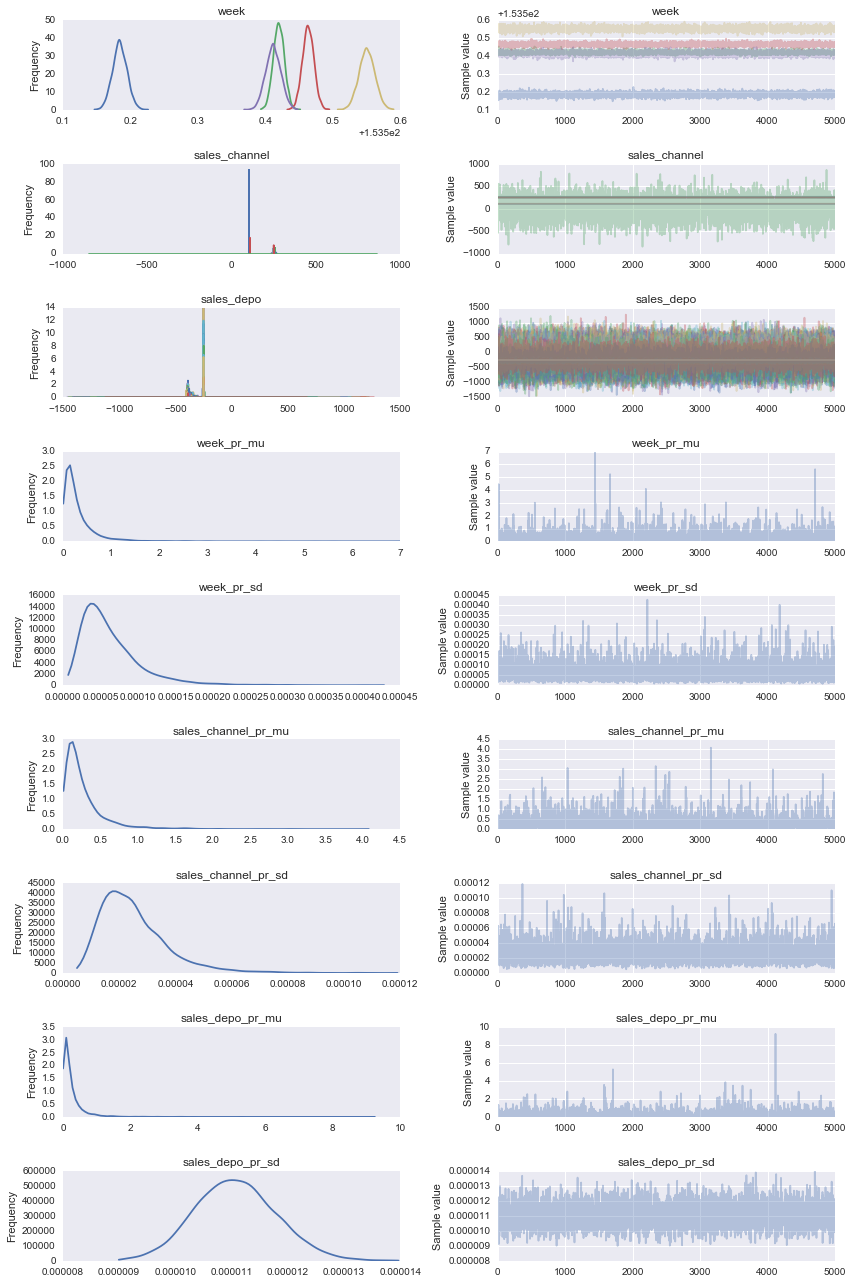

In [26]:
with simple_model:
    v_params = pymc3.variational.advi_minibatch(
        n=1000000,
        minibatch_tensors=minibatch_tensors,
        minibatch_RVs=[adjusted_demand],
        minibatches=minibatches,
        total_size=data.shape[0], 
        learning_rate=1e-2, 
        epsilon=1.0
    )
    trace = pymc3.variational.sample_vp(v_params, draws=5000)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e2b4d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124b0a390>]], dtype=object)

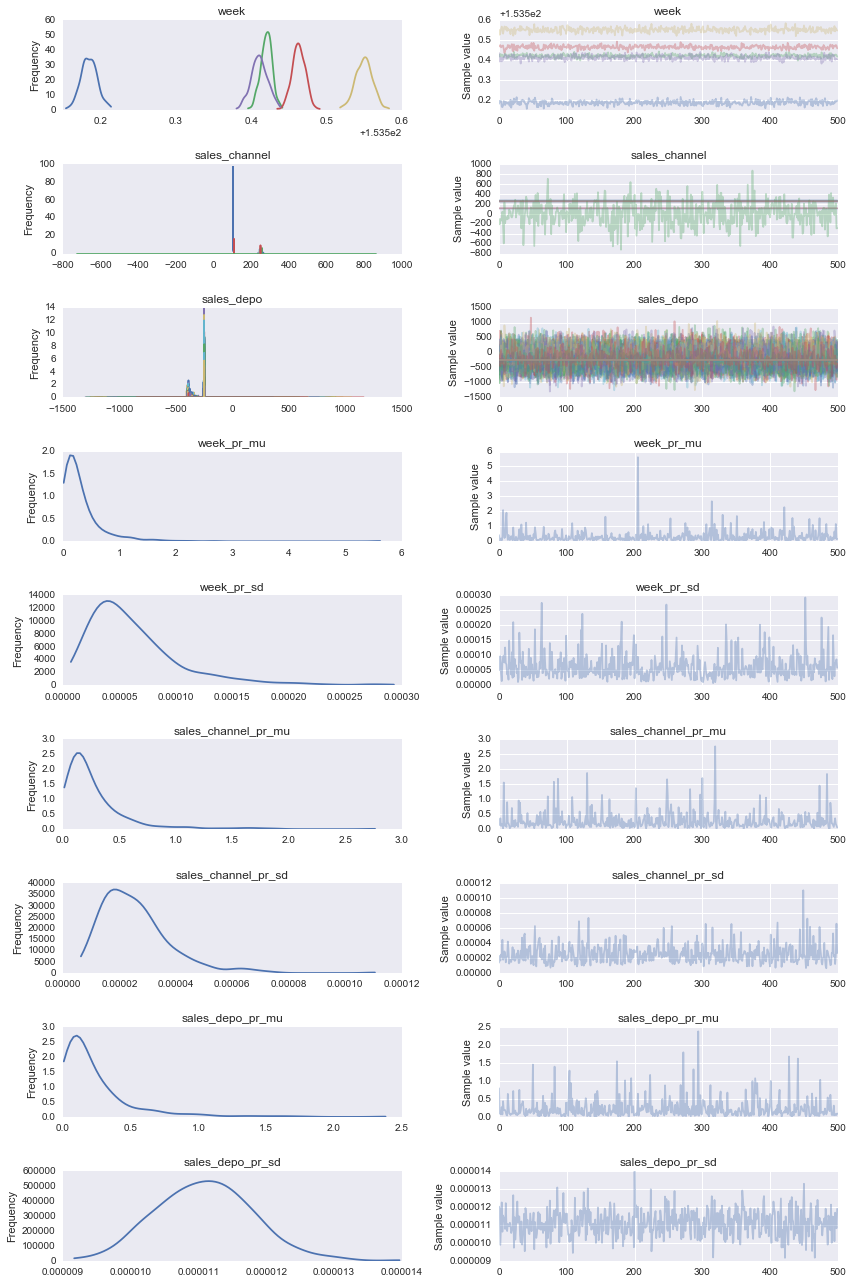

In [27]:
pymc3.traceplot(trace[-500:])

In [30]:
help(pymc3.sample_ppc)

Help on function sample_ppc in module pymc3.sampling:

sample_ppc(trace, samples=None, model=None, vars=None, size=None)
    Generate posterior predictive samples from a model given a trace.
    
    Parameters
    ----------
    trace : backend, list, or MultiTrace
        Trace generated from MCMC sampling
    samples : int
        Number of posterior predictive samples to generate. Defaults to the
        length of `trace`
    model : Model (optional if in `with` context)
        Model used to generate `trace`
    vars : iterable
        Variables for which to compute the posterior predictive samples.
        Defaults to `model.observed_RVs`.
    size : int
        The number of random draws from the distribution specified by the
        parameters in each sample of the trace.
    
    Returns
    -------
    Dictionary keyed by `vars`, where the values are the corresponding
    posterior predictive samples.



### 